In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import timeit
from datetime import datetime

%load_ext tensorboard

In [7]:
print("Using TensorFlow version %s" % tf.__version__)
import tensorflow.experimental.numpy as tnp

Using TensorFlow version 2.5.0-dev20210102


In [8]:
# ND Array == instance of  tf.experimental.numpy.ndarray
#             -> internally wraps tf.Tensor

# Create an ND array and check out different attributes.
ones = tnp.ones([5, 3], dtype=tnp.float32)
print("Created ND array with shape = %s, rank = %s, ""dtype = %s on device = %s\n" % (ones.shape, ones.ndim, ones.dtype, ones.data.device))

# Check out the internally wrapped `tf.Tensor` object.
print("The ND array wraps a tf.Tensor: %s\n" % ones.data)

# Try commonly used member functions.
print("ndarray.T has shape %s" % str(ones.T.shape))
print("narray.reshape(-1) has shape %s" % ones.reshape(-1).shape)


Created ND array with shape = (5, 3), rank = 2, dtype = float32 on device = /job:localhost/replica:0/task:0/device:CPU:0

The ND array wraps a tf.Tensor: tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]], shape=(5, 3), dtype=float32)

ndarray.T has shape (3, 5)
narray.reshape(-1) has shape 15


In [9]:
print("Type promotion for operations")
values = [tnp.asarray(1, dtype=d) for d in (tnp.int32, tnp.int64, tnp.float32, tnp.float64)]
for i, v1 in enumerate(values):
  for v2 in values[i+1:]:
    print("%s + %s => %s" % (v1.dtype, v2.dtype, (v1 + v2).dtype))

print("Type inference during array creation")
print("tnp.asarray(1).dtype == tnp.%s" % tnp.asarray(1).dtype)
print("tnp.asarray(1.).dtype == tnp.%s\n" % tnp.asarray(1.).dtype)

Type promotion for operations
int32 + int64 => int64
int32 + float32 => float64
int32 + float64 => float64
int64 + float32 => float64
int64 + float64 => float64
float32 + float64 => float64
Type inference during array creation
tnp.asarray(1).dtype == tnp.int32
tnp.asarray(1.).dtype == tnp.float64



In [10]:
x = tnp.ones([2, 3])
y = tnp.ones([3])
z = tnp.ones([1, 2, 1])
print("Broadcasting shapes %s, %s and %s gives shape %s" % (x.shape, y.shape, z.shape, (x + y + z).shape))

Broadcasting shapes (2, 3), (3,) and (1, 2, 1) gives shape (1, 2, 3)


In [11]:
# this interchange may cause data copies!!! (esp. for passing np.ndarray to tf numpy)
# ND array passed into NumPy function.
np_sum = np.sum(tnp.ones([2, 3]))
print("sum = %s. Class: %s" % (float(np_sum), np_sum.__class__))

# `np.ndarray` passed into TensorFlow NumPy function.
tnp_sum = tnp.sum(np.ones([2, 3]))
print("sum = %s. Class: %s" % (float(tnp_sum), tnp_sum.__class__))

sum = 6.0. Class: <class 'numpy.float64'>
sum = 6.0. Class: <class 'tensorflow.python.ops.numpy_ops.np_arrays.ndarray'>


1000

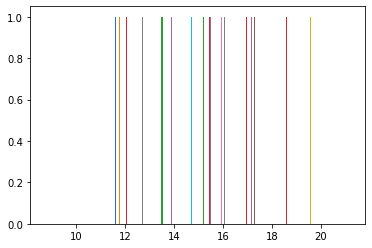

In [12]:
# It is easy to plot ND arrays, given the __array__ interface.
labels = 15 + 2 * tnp.random.randn(1000)
len(labels)
_ = plt.hist(labels)

In [13]:
x = tnp.ones([2]) + np.ones([2])
print("x = %s\nclass = %s" % (x, x.__class__))

x = ndarray<tf.Tensor([2. 2.], shape=(2,), dtype=float64)>
class = <class 'tensorflow.python.ops.numpy_ops.np_arrays.ndarray'>


In [14]:
x = tf.constant([1, 2])

# Convert `tf.Tensor` to `ndarray`.
tnp_x = tnp.asarray(x)
print(tnp_x)

# Convert `ndarray` to `tf.Tensor` can be done in following ways.
print(tnp_x.data)
print(tf.convert_to_tensor(tnp_x))

# Note that tf.Tensor.numpy() will continue to return `np.ndarray`.
print(x.numpy(), x.numpy().__class__)

ndarray<tf.Tensor([1 2], shape=(2,), dtype=int32)>
tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([1 2], shape=(2,), dtype=int32)
[1 2] <class 'numpy.ndarray'>


In [15]:
# ND array passed into TensorFlow function.
# This returns a `tf.Tensor`.
tf_sum = tf.reduce_sum(tnp.ones([2, 3], tnp.float32))
print("Output = %s" % tf_sum)

# `tf.Tensor` passed into TensorFlow NumPy function.
# This returns an ND array.
tnp_sum = tnp.sum(tf.ones([2, 3]))
print("Output = %s" % tnp_sum)

Output = tf.Tensor(6.0, shape=(), dtype=float32)
Output = ndarray<tf.Tensor(6.0, shape=(), dtype=float32)>


In [16]:
x = tnp.ones([2, 2]) + tf.ones([2, 1])
print("x = %s\nClass = %s" % (x, x.__class__))

x = tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32)
Class = <class 'tensorflow.python.framework.ops.EagerTensor'>


In [22]:
class Model(object):
#  """Model with a dense and a linear layer."""
    def __init__(self):
        self.weights = None

    def predict(self, inputs):
        if self.weights is None:
            size = inputs.shape[1]
            # Note that type `tnp.float32` is used for performance.
            stddev = tnp.sqrt(size).astype(tnp.float32)
            w1 = tnp.random.randn(size, 64).astype(tnp.float32) / stddev
            bias = tnp.random.randn(64).astype(tnp.float32)
            w2 = tnp.random.randn(64, 2).astype(tnp.float32) / 8
            self.weights = (w1, bias, w2)
        else:
            w1, bias, w2 = self.weights
        y = tnp.matmul(inputs, w1) + bias
        y = tnp.maximum(y, 0)  # Relu
        return tnp.matmul(y, w2)  # Linear projection

model = Model()
# Create input data and compute predictions.
print(model.predict(tnp.ones([2, 32], dtype=tnp.float32)))
print(model.weights)

def create_batch(batch_size=32):
#  """Creates a batch of input and labels."""
    return (tnp.random.randn(batch_size, 32).astype(tnp.float32),tnp.random.randn(batch_size, 2).astype(tnp.float32))

def compute_gradients(model, inputs, labels):
#  """Computes gradients of squared loss between model prediction and labels."""
    with tf.GradientTape() as tape:
        assert model.weights is not None
        # Note that `model.weights` need to be explicitly watched since they are not tf.Variables.
        tape.watch(model.weights)
        # Compute prediction and loss
        prediction = model.predict(inputs)
        loss = tnp.sum(tnp.square(prediction - labels))
        # This call computes the gradient through the computation above.
        return tape.gradient(loss, model.weights)

inputs, labels = create_batch()  
gradients = compute_gradients(model, inputs, labels)  
# Verify that gradients are of type ND array.
assert isinstance(gradients[0], tnp.ndarray)

ndarray<tf.Tensor(
[[-0.571265  0.542683]
 [-0.571265  0.542683]], shape=(2, 2), dtype=float32)>
(ndarray<<tf.Tensor: shape=(32, 64), dtype=float32, numpy=
array([[ 2.7971673e-01, -2.0902634e-02,  2.3262843e-01, ...,
        -9.4256150e-03,  2.2022738e-01, -2.5893027e-01],
       [-9.6556221e-05, -2.9957063e-02, -1.7519373e-01, ...,
         1.0354334e-01, -5.5686809e-02,  8.0912657e-02],
       [-1.8033135e-01,  5.8357317e-02,  1.6310488e-01, ...,
        -1.5995122e-02, -7.3345877e-02,  2.9494342e-01],
       ...,
       [-1.7130308e-01, -3.3424415e-02, -9.2471652e-02, ...,
         1.3585578e-01, -1.5599339e-02,  8.8118970e-02],
       [ 5.0635736e-02, -1.4859751e-01,  6.7666225e-02, ...,
         6.7930304e-02, -2.3089866e-01,  4.4580404e-02],
       [ 1.6832185e-01,  3.9510950e-01, -3.1958616e-01, ...,
         2.2902837e-02,  1.2933820e-01,  1.6916427e-01]], dtype=float32)>>, ndarray<<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 1.2630885 ,  0.298951  ,  0.03969102, -0.2

In [19]:
inputs, labels = create_batch(512)
print("Eager performance")
compute_gradients(model, inputs, labels)
print(timeit.timeit(lambda: compute_gradients(model, inputs, labels),
                    number=10)* 100, "ms")

print("\ntf.function compiled performance")
compiled_compute_gradients = tf.function(compute_gradients)
compiled_compute_gradients(model, inputs, labels)  # warmup
print(timeit.timeit(lambda: compiled_compute_gradients(model, inputs, labels),
                    number=10) * 100, "ms")

Eager performance


(ndarray<<tf.Tensor: shape=(32, 64), dtype=float32, numpy=
 array([[-3.6878880e-02, -4.2285824e-01, -1.3323547e+01, ...,
          1.2142377e+00,  2.3592346e+01, -2.8850470e+00],
        [ 2.7767455e-02,  5.7683039e-01, -1.2723574e+01, ...,
          5.0739288e+00,  5.1007832e+01, -1.7326290e+01],
        [ 1.7343797e-02,  1.0158749e+01,  4.5556396e+01, ...,
          2.3112207e+01,  7.2193542e+01, -3.6999718e+01],
        ...,
        [ 1.0608150e-01,  5.4015174e+00,  3.9306648e+01, ...,
          1.0580072e+01, -2.6720156e+01, -2.7604361e+01],
        [ 3.4141131e-02, -2.0888191e+01, -7.8890976e+01, ...,
         -3.7434006e+01, -1.9936989e+01,  5.6651421e+01],
        [-8.4357679e-02, -8.6374035e+00, -9.5639877e+00, ...,
         -1.3327133e+01, -4.8845348e+00,  1.1626429e+01]], dtype=float32)>>,
 ndarray<<tf.Tensor: shape=(64,), dtype=float32, numpy=
 array([-5.3140894e-02,  9.5286118e+01,  2.8991153e+02,  6.2652893e+00,
         1.5762982e+02,  8.3150146e+01,  8.8440315e+01, -3.58

3.1474899999921035 ms

tf.function compiled performance


[ndarray<<tf.Tensor: shape=(32, 64), dtype=float32, numpy=
 array([[-3.6878880e-02, -4.2285824e-01, -1.3323547e+01, ...,
          1.2142377e+00,  2.3592346e+01, -2.8850470e+00],
        [ 2.7767455e-02,  5.7683039e-01, -1.2723574e+01, ...,
          5.0739288e+00,  5.1007832e+01, -1.7326290e+01],
        [ 1.7343797e-02,  1.0158749e+01,  4.5556396e+01, ...,
          2.3112207e+01,  7.2193542e+01, -3.6999718e+01],
        ...,
        [ 1.0608150e-01,  5.4015174e+00,  3.9306648e+01, ...,
          1.0580072e+01, -2.6720156e+01, -2.7604361e+01],
        [ 3.4141131e-02, -2.0888191e+01, -7.8890976e+01, ...,
         -3.7434006e+01, -1.9936989e+01,  5.6651421e+01],
        [-8.4357679e-02, -8.6374035e+00, -9.5639877e+00, ...,
         -1.3327133e+01, -4.8845348e+00,  1.1626429e+01]], dtype=float32)>>,
 ndarray<<tf.Tensor: shape=(64,), dtype=float32, numpy=
 array([-5.3140894e-02,  9.5286118e+01,  2.8991153e+02,  6.2652893e+00,
         1.5762982e+02,  8.3150146e+01,  8.8440315e+01, -3.58

2.6182999999946333 ms


In [23]:
@tf.function
def vectorized_per_example_gradients(inputs, labels):
  def single_example_gradient(arg):
    inp, label = arg
    return compute_gradients(model,
                             tnp.expand_dims(inp, 0),
                             tnp.expand_dims(label, 0))
  # Note that a call to `tf.vectorized_map` semantically maps
  # `single_example_gradient` over each row of `inputs` and `labels`.
  # The interface is similar to `tf.map_fn`.
  # The underlying machinery vectorizes away this map loop which gives
  # nice speedups.
  return tf.vectorized_map(single_example_gradient, (inputs, labels))

batch_size = 128
inputs, labels = create_batch(batch_size)

per_example_gradients = vectorized_per_example_gradients(inputs, labels)
for w, p in zip(model.weights, per_example_gradients):
  print("Weight shape: %s, batch size: %s, per example gradient shape: %s " % (
      w.shape, batch_size, p.shape))

Weight shape: (32, 64), batch size: 128, per example gradient shape: (128, 32, 64) 
Weight shape: (64,), batch size: 128, per example gradient shape: (128, 64) 
Weight shape: (64, 2), batch size: 128, per example gradient shape: (128, 64, 2) 


In [24]:
print("All logical devices:", tf.config.list_logical_devices())
print("All physical devices:", tf.config.list_physical_devices())

# Try to get the GPU device. If unavailable, fallback to CPU.
try:
  device = tf.config.list_logical_devices(device_type="GPU")[0]
except IndexError:
  device = "/device:CPU:0"

All logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU')]
All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [26]:
print("Using device: %s" % str(device))
# Run operations in the `tf.device` scope.
# If a GPU is available, these operations execute on the GPU and outputs are
# placed on the GPU memory.
with tf.device(device):
  prediction = model.predict(create_batch(5)[0])

print("prediction is placed on %s" % prediction.data.device)

Using device: /device:CPU:0
prediction is placed on /job:localhost/replica:0/task:0/device:CPU:0


In [27]:
with tf.device("/device:CPU:0"):
  prediction_cpu = tnp.copy(prediction)
print(prediction.data.device)
print(prediction_cpu.data.device)


/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:CPU:0
